In [1]:
import numpy as np
import os 

In [2]:
def lu_decomposition(A):
    n = A.shape[0]
    L = np.zeros((n, n))
    U = np.zeros((n, n))  
    for i in range(n):
        L[i, i] = 1.0
        for j in range(i, n):
            U[i, j] = A[i, j] - np.dot(L[i, :i], U[:i, j])
        for j in range(i+1, n):
            L[j, i] = (A[j, i] - np.dot(L[j, :i], U[:i, i])) / U[i, i]
    return L, U
def solve_lu(A, b):
    L, U = lu_decomposition(A)
    n = A.shape[0]
    y = np.zeros((n, 1))
    x = np.zeros((n, 1))

    # Solve Ly = b using forward substitution
    for i in range(n):
        y[i, 0] = b[i, 0] - np.dot(L[i, :i], y[:i, 0])

    # Solve Ux = y using backward substitution
    for i in range(n - 1, -1, -1):
        x[i, 0] = (y[i, 0] - np.dot(U[i, i+1:], x[i+1:, 0])) / U[i, i]
    return x

In [3]:
def solve_linear_system(A, b):
    try:
        # Attempt to solve the system using numpy.linalg.solve()
        X = np.linalg.solve(A, b)
        return X
    except np.linalg.LinAlgError:
        # Handle the case where A is singular (not invertible)
        raise ValueError("Matrix A is singular, and the system has no unique solution.")

In [4]:
def get_abcd(Grid_points,rho,dt,dx,f,A_n,Area,u_n,p_s):
    b=np.ones((Grid_points))
    a=np.ones((Grid_points))
    c=np.ones((Grid_points-1))
    d=np.ones((Grid_points))
    for i in range (0,Grid_points):
        a[i]=((rho*Area[2*i]/dt)+(f*rho*u_n[i]*p_s[2*i]/8))
        b[i]=((rho*Area[2*i]/(2*dx)))
        d[i]=((rho*A_n[2*i]*u_n[i]/dt))  
        if i<Grid_points-1:
            c[i]=(Area[(2*i)+1]/dx)             
    return a,b,c,d        
           

In [5]:
#for momentum equation final draft
def solve_momentum(a, b, c, d, p_star,Grid_points,u_boundary):
    """
    Calculate u_star vector using the provided inputs and matrix inversion.

    Parameters:
    a (numpy.ndarray): Coefficients a_{i+1/2}^{n+1}.
    b (numpy.ndarray): Coefficients b_{i-1/2}^{n+1} & b_{i+3/2}^{n+1}.
    c (numpy.ndarray): Coefficients c_i^{n+1}.
    d (numpy.ndarray): Coefficients d_{i+1/2}^{n}.
    p_star (numpy.ndarray): Guessed pressure vector.

    Returns:
    u_star (numpy.ndarray): Calculated u_star vector.
    """
    #len of p_star is equal to length of a-1;
    # Calculate the size of the system (number of equations)
    n =Grid_points
    if n>2:
        # Initialize the coefficient matrix A and the right-hand side vector b
        A = np.zeros((n-2, n))
        u_star=np.zeros((n,1))
        Rhs=np.zeros((n-2,1))
        # Populate the coefficient matrix and the right-hand side vector
        for i in range(1,n-1):
            A[i-1, i-1] =b[i-1]
            A[i-1,i] = (-1*a[i])
            A[i-1,i+1]=b[i+1]
            const = ((c[i] * p_star[i]) - (c[i-1] * p_star[i-1]) - d[i])
            Rhs[i-1,0]=const
        #print(Rhs[0,0],Rhs[n-3,0])
        #print(A,Rhs) 
        Rhs[0,0]= Rhs[0,0]-(A[0,0]*u_boundary[0])
        Rhs[n-3,0]=Rhs[n-3,0]-(A[n-3,n-1]*u_boundary[1])
        #print(Rhs[0,0],Rhs[n-3,0])     
        coefficient_matrix=A[:,1:n-1]
        #print(coefficient_matrix,Rhs)       
        u_star=solve_linear_system(coefficient_matrix,Rhs)
        #print(solve_linear_system(coefficient_matrix,Rhs))

    return u_star    

In [6]:
#pressure correction coefficients:
def get(Grid_points,u_n,u_star,Area,A_n,p_s,rho,dx,dt,f):
    alpha=np.zeros(Grid_points-1)
    beta=np.zeros(Grid_points-1)
    gama=np.zeros(Grid_points-1)
    z=np.zeros(Grid_points-1)
    if (Grid_points>1): 
        for i in range(1,(2*Grid_points)-2,2):
            a_left=(rho*Area[i-1]/dx)
            b_left=(rho*Area[i-1]/dt)
            c_left=(f*rho*u_n[(i-1)//2]*p_s[i-1]/8) //2
            a_right=(rho*Area[i+1]/dx)
            b_right=(rho*Area[i+1]/dt)
            c_right=(f*rho*u_n[(i+1)//2]*p_s[i+1]/8)
            beta1_left=(a_left/(b_left+c_left))
            gama1_right=(a_right/(b_right+c_right))

            alpha[(i-1)//2]=(beta1_left+gama1_right)*(Area[i]/dx)
            beta[(i-1)//2]=beta1_left*(Area[i]/dx)
            gama[(i-1)//2]=gama1_right*(Area[i]/dx)
            z[(i-1)//2]=((a_left*(u_star[(i-1)//2]))-(a_right*(u_star[(i+1)//2]))+(((rho*A_n[i])-(rho*Area[i]))/dt))
    return alpha,gama,beta,z


In [7]:
def Combine(u_star1,u_star,Grid_points):
    u_star[1:Grid_points-1]=u_star1[:, 0]
    return u_star

In [8]:
def add(p_star,add_p,Grid_points):
    p_star[1:Grid_points-2] += add_p[:,0]
    return p_star

In [9]:
def correct_pressure(Grid_points,alpha,beta,gama,z,p_entry,p_exit):
    """
    Calculate P' vector using the provided inputs and matrix inversion.

    Parameters:
    alpha (numpy.ndarray):
    beta (numpy.ndarray): 
    gama (numpy.ndarray):
    z(numpy.ndarray):

    Returns:
    p' (numpy.ndarray): Calculated p'(It is the value of p that has to be added) vector.
    """
    n=Grid_points
    A1 = np.zeros((n-3, n-1))
    Rhs1=np.zeros((n-3,1))
    #populate the coefficent matrix
    for i in range(1,n-2):
        A1[i-1,i-1] = gama[i-1]
        A1[i-1,i] = (-1*alpha[i-1])
        A1[i-1,i+1]= (beta[i-1])
        const = (-1*z[i-1])
        Rhs1[i-1,0]=const
    #print(A1,Rhs1)    
    Rhs1[0,0]=Rhs1[0,0]-(A1[0,0]*p_entry)
    Rhs1[n-4,0]=Rhs1[n-4,0]-(A1[n-4,n-2]*p_exit)
    co_efficientmatrix1=A1[:,1:n-2] 
    #print(co_efficientmatrix1,Rhs1)
    p_=solve_lu(co_efficientmatrix1,Rhs1)    
    return p_

    
    

In [10]:
def Momentum(p_star,u_n,Grid_points,rho,dt,dx,f,A_n,Area,p_s,u_boundary):
    """    
    #Mometum equation part 
    """
    a_values,b_values,c_values,d_values=get_abcd(Grid_points,rho,dt,dx,f,A_n,Area,u_n,p_s)#solve co-efficients at all grid points
    #print(u_n)
    #define Boubdary conditions for velocity
    u_star1= solve_momentum(a_values, b_values, c_values, d_values, p_star,Grid_points,u_boundary)# Solve momentum equation to find intermediate velocity (u_star)
    #print(u_n)
    #print(u_star,u_star1)
    u_star=Combine(u_star1,u_n,Grid_points)
    #print(u_n,'at combine')
    #print(u_star)
    return u_star

In [11]:
def Pressure_adjust(p_star,u_star,Grid_points,u_n,Area,A_n,p_s,rho,dx,dt,f,p_boundary):

    """    
    #Pressure Adjustment part 
    """    
    alpha,beta,gama,z=get(Grid_points,u_n,u_star,Area,A_n,p_s,rho,dx,dt,f) 
    #print(alpha,beta,gama,z)
    #print(alpha.size)
    p_inlet=p_boundary[0]
    p_exit=p_boundary[1]
    add_p1=correct_pressure(Grid_points,alpha,beta,gama,z,p_inlet,p_exit)#Solve pressure correction equation 
    #print(add_p1)
    return add_p1 


In [12]:
import matplotlib.pyplot as plt
def visualize(p_star1,u_star1):
# Generate example 1-D vectors (replace with your actual data)
    vector1 = p_star1 # 50 random values for vector 1
    vector2 = u_star1  # 50 random values for vector 2 
    # Line Plot
    plt.plot(vector1, label='Vector 1')
    plt.plot(vector2, label='Vector 2')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('1-D Vector Line Plot')
    plt.show()


In [13]:
# simple algorithm 
def unsteady_1D_flow(A_n,u_n,p_star,p_s,Grid_points,rho,dx,dt,f,n,u_boundary,p_boundary):
    for t in range(0,n):
        Area=np.ones((2*Grid_points)-1)
        u_star=Momentum(p_star,u_n,Grid_points,rho,dt,dx,f,A_n,Area,p_s,u_boundary)
        #print(u_n)
        p_add=Pressure_adjust(p_star,u_star,Grid_points,u_n,Area,A_n,p_s,rho,dx,dt,f,p_boundary)
        p_star1=p_star
        #print(p_star1)
        #print(u_star)
        #print(u_n)
        a=4
        while(np.all(a>0)):
            p_updated=add(p_star1,p_add,Grid_points)
            u_star1=Momentum(p_updated,u_n,Grid_points,rho,dt,dx,f,A_n,Area,p_s,u_boundary)
            p_add=Pressure_adjust(p_updated,u_star1,Grid_points,u_n,Area,A_n,p_s,rho,dx,dt,f,p_boundary)
            p_star1=p_updated
            a=a-1
            #print(u_n)
            #print('Pressure field and its corresponding velocity field')
            print(p_star1)
            print(u_star1)
            visualize(p_star1,u_star1)
    return u_star1,p_star1

[1. 1. 1. 1. 1.] [1. 1. 1. 1.]
[1.         0.38513743 0.71394639 1.        ]
[1.         4.90571073 5.3714897  4.24187775 1.        ]


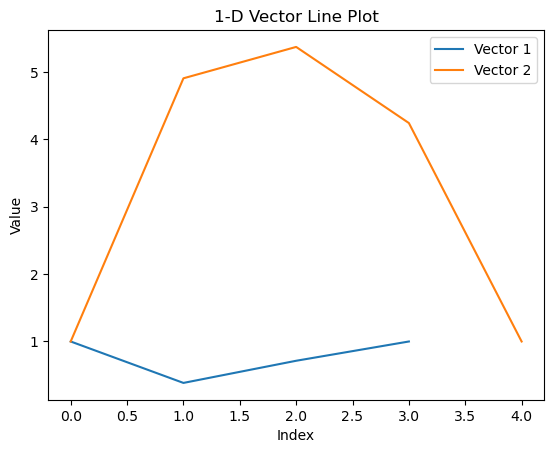

[ 1.         -1.93160386 -0.65266125  1.        ]
[1.         6.92870266 5.68032888 3.87481794 1.        ]


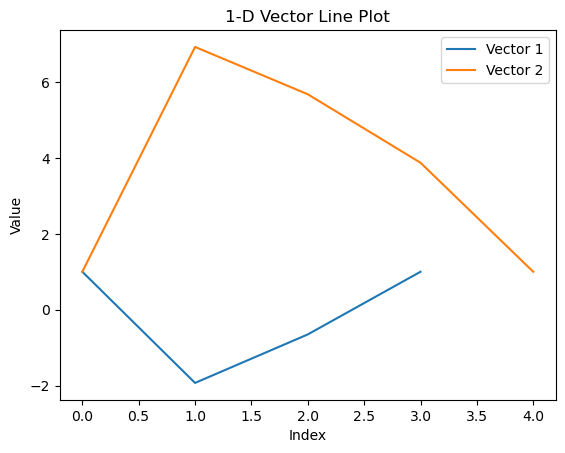

[ 1.         -5.52907975 -1.76595107  1.        ]
[1.         8.65965734 4.40379756 2.56729201 1.        ]


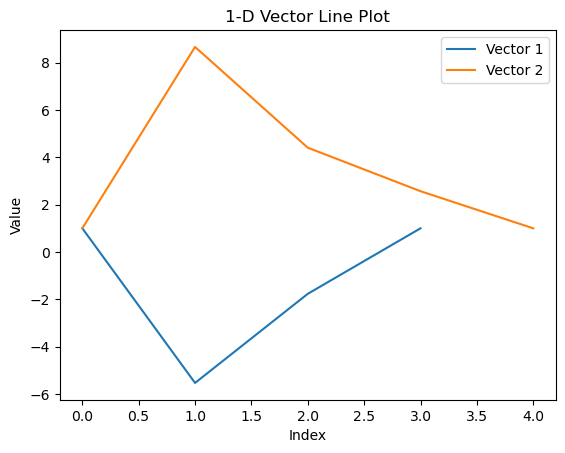

[ 1.         -9.92955698 -1.46178247  1.        ]
[1.         9.83813581 0.79656424 0.75992348 1.        ]


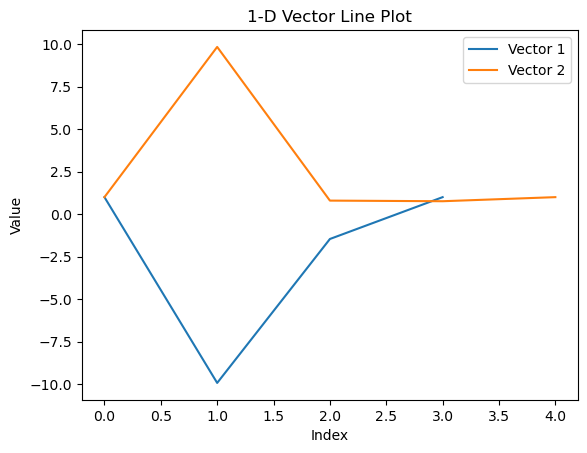

[1.         9.83813581 0.79656424 0.75992348 1.        ] [ 1.         -9.92955698 -1.46178247  1.        ]


In [14]:
# Define constants and parameters

"""
const paramers through-out the analysis
"""
n = 1  # Number of time steps
L = 1.0  # Length of the 1D domain
dx = 1 # Spatial grid size
dt = 1  # Time step size
rho = 1.0 # Density
f = 1.0   # Source term
g = 10.0   # Gravitational acceleration
Grid_points=5 #Total number of grid points
u_boundary=np.ones(2)
p_boundary=np.ones(2) 





"""
Variables w.r.t time
"""
# Initialize arrays for velocity (u) and pressure (p) at staggered grid locations
#u_star= np.ones(Grid_points)
p_star = np.ones(Grid_points-1)
A_n=np.ones((2*Grid_points)-1)
p_s=np.ones((2*Grid_points)-1)
u_n = np.ones(Grid_points) # Velocity at staggered grid locations
print(u_n,p_star)




"""
Final result 
"""
velocity, Pressure =unsteady_1D_flow(A_n,u_n,p_star,p_s,Grid_points,rho,dx,dt,f,n,u_boundary,p_boundary)
print(velocity,Pressure)


In [15]:
d=15.4 mm
l=2 m
inletmassflux=900 kg/m2.s
p_exit=1 atm


SyntaxError: invalid syntax (1469361190.py, line 1)